<a href="https://colab.research.google.com/github/karthikyandrapu/Final-Year-Project/blob/main/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Named Entity Recognition for Telugu Texts using BERT**

**Install Dependencies**

In [1]:
!pip install tensorflow==2.16.1
!pip install transformers==4.41.0
!pip install datasets==2.20.0
!pip install pandas==2.1.4
!pip install numpy==1.26.4
!pip install scikit-learn==1.4.1.post1
!pip install matplotlib==3.8.3
!pip install seaborn==0.13.2
!pip install flask==3.0.2
!pip install gdown==5.1.0

  Using cached flask-3.0.2-py3-none-any.whl.metadata (3.6 kB)
Using cached flask-3.0.2-py3-none-any.whl (101 kB)
  Attempting uninstall: flask
    Found existing installation: Flask 3.1.0
    Uninstalling Flask-3.1.0:
      Successfully uninstalled Flask-3.1.0
  Attempting uninstall: gdown
    Found existing installation: gdown 5.2.0
    Uninstalling gdown-5.2.0:
      Successfully uninstalled gdown-5.2.0


**Import Dependencies**

In [19]:
import tensorflow as tf
import pandas as pd
import numpy as np
from transformers import TFBertModel, BertTokenizerFast
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from flask import Flask, request, jsonify
import os
import json
import re
import logging
from datasets import load_dataset
from google.colab import drive
import shutil
import ast
import torch
print("Successfully Imported")

Successfully Imported


**Set up logging**

In [22]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

**Mount Google Drive**

In [27]:
drive.mount('/content/drive', force_remount=True)
print("Mounted Successfully")

Mounted at /content/drive
Mounted Successfully


**Define paths**

In [6]:
model_name = 'google/bert_uncased_L-12_H-768_A-12'
cache_dir = '/content/drive/MyDrive/NER/bert_uncased_L-12_H-768_A-12'
INPUT_CSV = '/content/drive/MyDrive/NER/telugu_ner_data_uncleaned.csv'
OUTPUT_CSV = '/content/drive/MyDrive/NER/telugu_ner_data.csv'
print("Successfully paths defined")

Successfully paths defined


**Function to validate cache directory**

In [7]:
def is_valid_cache(cache_path):
    required_files = ['config.json']
    if not os.path.isdir(cache_path):
        return False
    existing_files = os.listdir(cache_path)
    logger.info(f"Cache directory contents: {existing_files}")
    print(f"Cache directory contents: {existing_files}")
    return all(os.path.isfile(os.path.join(cache_path, f)) for f in required_files)

**Initialize tokenizer and model**

In [8]:
try:
    logger.info(f"Checking cache at {cache_dir}")
    if is_valid_cache(cache_dir):
        logger.info(f"Loading tokenizer and model from Drive cache: {cache_dir}")
        tokenizer = BertTokenizerFast.from_pretrained(cache_dir)
        bert_model = TFBertModel.from_pretrained(cache_dir)
    else:
        if os.path.exists(cache_dir):
            logger.warning(f"Invalid cache at {cache_dir}. Deleting and reloading from Hugging Face.")
            shutil.rmtree(cache_dir, ignore_errors=True)
        logger.info(f"Loading {model_name} from Hugging Face and caching to Drive")
        tokenizer = BertTokenizerFast.from_pretrained(model_name, from_pt=True)
        bert_model = TFBertModel.from_pretrained(model_name, from_pt=True)
        # Save to Drive
        try:
            os.makedirs(cache_dir, exist_ok=True)
            tokenizer.save_pretrained(cache_dir)
            bert_model.save_pretrained(cache_dir)
            logger.info(f"Model and tokenizer cached to {cache_dir}")
        except Exception as e:
            logger.warning(f"Failed to cache to Drive: {str(e)}. Proceeding without caching.")
except Exception as e:
    logger.error(f"Failed to load {model_name}: {str(e)}. Check network, Drive access, or disk space.")
    raise

# Log to clarify PyTorch weights warning
logger.info("Note: Warnings about unused PyTorch weights (e.g., cls.predictions) are expected, "
            "as they are for pretraining tasks not used in NER. "
            "Pooler gradient warnings, if any, are harmless as pooler is unused in NER output.")

Cache directory contents: ['tokenizer_config.json', 'special_tokens_map.json', 'vocab.txt', 'tokenizer.json', 'config.json', 'tf_model.h5']


All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at /content/drive/MyDrive/NER/bert_uncased_L-12_H-768_A-12.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


**Verify vocabulary size**

In [9]:
vocab_size = tokenizer.vocab_size
logger.info(f"Tokenizer vocab size: {vocab_size}")
assert vocab_size > 30000, "Unexpected vocab size"

**Define Tag Mappings**

In [10]:
tag2id = {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-LOC': 3, 'I-LOC': 4, 'B-ORG': 5, 'I-ORG': 6}
id2tag = {v: k for k, v in tag2id.items()}
logger.info(f"Tag mappings: {tag2id}")
print("Defined Tag Mappings")

Defined Tag Mappings


**Pre-clean the CSV**

In [11]:
def parse_field(field):
    """Try to parse a string as a list, or fallback to space-splitting."""
    if isinstance(field, str):
        try:
            return ast.literal_eval(field)
        except (ValueError, SyntaxError):
            try:
                return json.loads(field)
            except json.JSONDecodeError:
                return field.strip().split()
    return field

def is_token_list(lst):
    return all(isinstance(item, str) and (item.startswith('B-') or item == 'O') for item in lst)

def clean_ner_csv(input_path, output_path):
    if not os.path.exists(input_path):
        print(f"Input file not found: {input_path}")
        return

    df = pd.read_csv(input_path, encoding='utf-8')
    cleaned_rows = []
    skipped = 0

    for idx, row in df.iterrows():
        tokens_raw = row.get('tokens')
        labels_raw = row.get('labels')

        tokens = parse_field(tokens_raw)
        labels = parse_field(labels_raw)

        # Swap if needed
        if is_token_list(labels) and not is_token_list(tokens):
            tokens, labels = labels, tokens

        # Validate lists
        if not isinstance(tokens, list) or not isinstance(labels, list):
            skipped += 1
            continue

        if len(tokens) != len(labels):
            skipped += 1
            continue

        cleaned_rows.append({'tokens': tokens, 'labels': labels})

    # Save cleaned CSV
    cleaned_df = pd.DataFrame(cleaned_rows)
    cleaned_df.to_csv(output_path, index=False, encoding='utf-8')
    print(f"Cleaned CSV saved: {output_path}")
    print(f"Total rows cleaned: {len(cleaned_df)}")
    print(f"Total rows skipped: {skipped}")

# Run the cleaning
clean_ner_csv(INPUT_CSV, OUTPUT_CSV)

Cleaned CSV saved: /content/drive/MyDrive/NER/telugu_ner_data.csv
Total rows cleaned: 228273
Total rows skipped: 0


**Load Dataset from CSV**

In [12]:
def load_csv_data(csv_path='/content/drive/MyDrive/NER/telugu_ner_data.csv'):
    logger.info(f"Attempting to load CSV dataset from {csv_path}")
    print(f"[INFO] Attempting to load CSV dataset from {csv_path}")

    if not os.path.exists(csv_path):
        logger.error(f"CSV file not found: {csv_path}")
        print(f"[ERROR] CSV file not found: {csv_path}")
        return None, None
    try:
        df = pd.read_csv(csv_path, encoding='utf-8')
        logger.info(f"CSV columns: {df.columns.tolist()}")
        print(f"[INFO] CSV columns: {df.columns.tolist()}")
        logger.info(f"First row sample: {df.iloc[0].to_dict() if not df.empty else 'Empty CSV'}")
        print(f"[INFO] First row sample: {df.iloc[0].to_dict() if not df.empty else 'Empty CSV'}")
        logger.info(f"Dataset head:\n{df.head() if not df.empty else 'Empty CSV'}")
        print(f"[INFO] Dataset head:\n{df.head() if not df.empty else 'Empty CSV'}")


        expected_cols = {'tokens', 'labels'}
        if not expected_cols.issubset(df.columns):
            logger.error(f"Missing columns. Expected {expected_cols}, found {df.columns}")
            print(f"[ERROR] Missing columns. Expected {expected_cols}, found {df.columns}")
            return None, None

        texts, labels = [], []
        for idx, row in df.iterrows():
            try:
                tokens = row['tokens']
                if isinstance(tokens, str):
                    try:
                        tokens = ast.literal_eval(tokens)
                    except (ValueError, SyntaxError):
                        tokens = json.loads(tokens)
                if not isinstance(tokens, (list, tuple)) or not tokens:
                    logger.warning(f"Row {idx}: Invalid tokens: {tokens}")
                    print(f"[WARNING] Row {idx}: Invalid tokens: {tokens}")
                    continue

                tags = row['labels']
                if isinstance(tags, str):
                    try:
                        tags = ast.literal_eval(tags)
                    except (ValueError, SyntaxError):
                        tags = json.loads(tags)
                if not isinstance(tags, (list, tuple)) or not tags:
                    logger.warning(f"Row {idx}: Invalid labels: {tags}")
                    print(f"[WARNING] Row {idx}: Invalid labels: {tags}")
                    continue

                if len(tokens) != len(tags):
                    logger.warning(f"Row {idx}: Mismatched lengths: tokens={tokens}, tags={tags}")
                    print(f"[WARNING] Row {idx}: Mismatched lengths: tokens={tokens}, tags={tags}")
                    continue

                tag_ids = [tag2id.get(tag, 0) for tag in tags]
                if not all(isinstance(id_, int) and 0 <= id_ <= 6 for id_ in tag_ids):
                    logger.warning(f"Row {idx}: Invalid tag IDs: {tag_ids}, tags={tags}")
                    print(f"[WARNING] Row {idx}: Invalid tag IDs: {tag_ids}, tags={tags}")
                    continue

                texts.append(tokens)
                labels.append(tag_ids)
            except Exception as e:
                logger.warning(f"Row {idx}: Error processing: {str(e)}, row={row.to_dict()}")
                print(f"[WARNING] Row {idx}: Error processing: {str(e)}, row={row.to_dict()}")
                continue

        logger.info(f"Loaded {len(texts)} valid samples from CSV")
        print(f"[INFO] Loaded {len(texts)} valid samples from CSV")
        logger.info(f"CSV columns: {df.columns.tolist()}")
        print(f"[INFO] CSV columns: {df.columns.tolist()}")
        df_texts = pd.DataFrame({'tokens': texts, 'labels': labels})
        logger.info(df_texts.info())
        print("Dataset Info:")
        print(df_texts.info())

        logger.info(df_texts.shape)
        print("Dataset Shape")
        print(df_texts.shape)

        logger.info(df_texts.describe())
        print("Describe")
        print(df_texts.describe())

        logger.info(df_texts.isnull().sum())
        print(df_texts.isnull().sum())

        return texts, labels
    except Exception as e:
        logger.error(f"Failed to load CSV: {str(e)}. Falling back to WikiANN")
        print(f"[ERROR] Failed to load CSV: {str(e)}. Falling back to WikiANN")
        return None, None

def load_wikiann_data():
    logger.info("Loading WikiANN Telugu dataset as fallback")
    print("[INFO] Loading WikiANN Telugu dataset as fallback")
    try:
        dataset = load_dataset("wikiann", "te")

        def process_example(example):
            tokens = example['tokens']
            ner_tags = example['ner_tags']
            if not tokens or not ner_tags or len(tokens) != len(ner_tags):
                logger.warning(f"Invalid sample: tokens={tokens}, tags={ner_tags}")
                print(f"[WARNING] Invalid sample: tokens={tokens}, tags={ner_tags}")
                return None
            if not all(isinstance(tag, int) and 0 <= tag <= 6 for tag in ner_tags):
                logger.warning(f"Invalid tags: tags={ner_tags}")
                print(f"[WARNING] Invalid tags: tags={ner_tags}")
                return None
            return tokens, ner_tags

        train_data = [x for x in map(process_example, dataset['train']) if x]
        val_data = [x for x in map(process_example, dataset['validation']) if x]
        test_data = [x for x in map(process_example, dataset['test']) if x]

        train_texts, train_labels = zip(*train_data) if train_data else ([], [])
        val_texts, val_labels = zip(*val_data) if val_data else ([], [])
        test_texts, test_labels = zip(*test_data) if test_data else ([], [])

        return (list(train_texts), list(train_labels),
                list(val_texts), list(val_labels),
                list(test_texts), list(test_labels))
    except Exception as e:
        logger.error(f"Failed to load WikiANN: {str(e)}")
        print(f"[ERROR] Failed to load WikiANN: {str(e)}")
        raise

def augment_data(texts, labels):
    logger.info("Applying data augmentation")
    print("[INFO] Applying data augmentation")
    aug_texts, aug_labels = [], []
    for text, label in zip(texts, labels):
        aug_texts.append(text)
        aug_labels.append(label)
        if np.random.rand() < 0.3:
            new_text, new_label = [], []
            for t, l in zip(text, label):
                new_text.append(t)
                new_label.append(l)
                if l == 0 and np.random.rand() < 0.5:
                    new_text.append(t)
                    new_label.append(l)
            aug_texts.append(new_text)
            aug_labels.append(new_label)
    logger.info(f"Augmented to {len(aug_texts)} samples")
    print(f"[INFO] Augmented to {len(aug_texts)} samples")
    return aug_texts, aug_labels

def validate_labels(texts, labels):
    logger.info("Validating labels")
    print("[INFO] Validating labels")
    valid_texts, valid_labels = [], []
    for text, label in zip(texts, labels):
        if not text or not label or len(text) != len(label):
            logger.warning(f"Skipping invalid: text={text}, label={label}")
            print(f"[WARNING] Skipping invalid: text={text}, label={label}")
            continue
        if not all(isinstance(l, int) and l in tag2id.values() for l in label):
            logger.warning(f"Invalid labels: {label}")
            print(f"[WARNING] Invalid labels: {label}")
            continue
        valid_texts.append(text)
        valid_labels.append(label)
    logger.info(f"Validated: {len(valid_texts)} samples retained")
    print(f"[INFO] Validated: {len(valid_texts)} samples retained")
    return valid_texts, valid_labels

logger.info("Loading data")
print("[INFO] Loading data")
train_texts, train_labels = load_csv_data()
if train_texts is None or not train_texts:
    logger.warning("CSV loading failed or empty. Using WikiANN dataset.")
    print("[WARNING] CSV loading failed or empty. Using WikiANN dataset.")
    train_texts, train_labels, val_texts, val_labels, test_texts, test_labels = load_wikiann_data()
else:
    train_texts, temp_texts, train_labels, temp_labels = train_test_split(
        train_texts, train_labels, test_size=0.2, random_state=42
    )
    val_texts, test_texts, val_labels, test_labels = train_test_split(
        temp_texts, temp_labels, test_size=0.5, random_state=42
    )

train_texts, train_labels = augment_data(train_texts, train_labels)
train_texts, train_labels = validate_labels(train_texts, train_labels)
val_texts, val_labels = validate_labels(val_texts, val_labels)
test_texts, test_labels = validate_labels(test_texts, test_labels)

logger.info(f"Train size: {len(train_texts)}, Validation size: {len(val_texts)}, Test size: {len(test_texts)}")
print(f"[INFO] Train size: {len(train_texts)}, Validation size: {len(val_texts)}, Test size: {len(test_texts)}")

[INFO] Loading data
[INFO] Attempting to load CSV dataset from /content/drive/MyDrive/NER/telugu_ner_data.csv
[INFO] CSV columns: ['tokens', 'labels']
[INFO] First row sample: {'tokens': "['O', 'B-LOC', 'B-LOC', 'B-LOC', 'O', 'O', 'O', 'O', 'B-LOC', 'O']", 'labels': "['ఈ', 'గ్రామం', 'చేవేండ్ర', 'గ్రామ', 'పంచాయతీ', 'పరిధిలోని', 'ఒక', 'శివారు', 'గ్రామం', '.']"}
[INFO] Dataset head:
                                              tokens  \
0  ['O', 'B-LOC', 'B-LOC', 'B-LOC', 'O', 'O', 'O'...   
1  ['B-LOC', 'O', 'B-MISC', 'B-LOC', 'B-LOC', 'B-...   
2  ['B-NAME', 'B-NAME', 'B-MISC', 'O', 'B-MISC', ...   
3  ['B-NAME', 'O', 'B-LOC', 'B-LOC', 'O', 'B-LOC'...   
4  ['B-NAME', 'O', 'B-LOC', 'B-LOC', 'B-LOC', 'O'...   

                                              labels  
0  ['ఈ', 'గ్రామం', 'చేవేండ్ర', 'గ్రామ', 'పంచాయతీ'...  
1  ['మధ్యప్రదేశ్', 'రాష్ట్ర', '51', 'జిల్లాలలో', ...  
2  ['నెంబర్', 'వన్', '1994', 'జనవరి', '14', 'న', ...  
3  ['గుమ్మసముద్రం', ',', 'చిత్తూరు', 'జిల్లా', ',...  
4  ['

**Tokenize and Align Labels**

In [13]:
def tokenize_and_align_labels(texts, labels, max_len=128):
    logger.info("Tokenizing and aligning labels")
    print("[INFO] Tokenizing and aligning labels")
    input_ids, attention_masks, label_ids = [], [], []

    for text, label in zip(texts, labels):
        try:
            if not text or not label or len(text) != len(label):
                logger.warning(f"Skipping invalid: text={text}, label={label}")
                print(f"[WARNING] Skipping invalid: text={text}, label={label}")
                continue
            text_str = ' '.join(map(str, text))
            if not text_str.strip():
                logger.warning(f"Empty text: {text}")
                print(f"[WARNING] Empty text: {text}")
                continue

            tokenized = tokenizer(
                text,
                max_length=max_len,
                padding='max_length',
                truncation=True,
                return_tensors='tf',
                is_split_into_words=True,
                return_offsets_mapping=False
            )

            input_id = tokenized['input_ids'][0]
            attention_mask = tokenized['attention_mask'][0]
            word_ids = tokenized.word_ids(batch_index=0)

            if tf.reduce_max(input_id).numpy() >= tokenizer.vocab_size:
                logger.warning(f"Invalid token IDs: text={text}")
                print(f"[WARNING] Invalid token IDs: text={text}")
                continue

            aligned_labels = [-100] * max_len
            label_idx = 0
            prev_word_id = None

            for i, word_id in enumerate(word_ids):
                if word_id is None:
                    aligned_labels[i] = -100
                    continue
                if word_id != prev_word_id:
                    if label_idx >= len(label):
                        logger.warning(f"Label index out of range: text={text}")
                        print(f"[WARNING] Label index out of range: text={text}")
                        break
                    aligned_labels[i] = label[label_idx]
                    label_idx += 1
                else:
                    aligned_labels[i] = aligned_labels[i-1] if i > 0 else -100
                prev_word_id = word_id

            input_ids.append(input_id)
            attention_masks.append(attention_mask)
            label_ids.append(aligned_labels)
        except Exception as e:
            logger.warning(f"Error processing: text={text}, error={str(e)}")
            print(f"[WARNING] Error processing: text={text}, error={str(e)}")
            continue

    if not input_ids:
        logger.error("No valid samples tokenized")
        print("[ERROR] No valid samples tokenized")
        raise ValueError("Tokenization failed for all samples")

    input_ids = tf.convert_to_tensor(input_ids)
    attention_masks = tf.convert_to_tensor(attention_masks)
    label_ids = tf.convert_to_tensor(label_ids)

    logger.info(f"Tokenized shapes: input_ids={input_ids.shape}, masks={attention_masks.shape}, labels={label_ids.shape}")
    print(f"[INFO] Tokenized shapes: input_ids={input_ids.shape}, masks={attention_masks.shape}, labels={label_ids.shape}")

    return input_ids, attention_masks, label_ids

# Tokenize
max_len = 128
train_inputs, train_masks, train_labels_ids = tokenize_and_align_labels(train_texts, train_labels, max_len)
val_inputs, val_masks, val_labels_ids = tokenize_and_align_labels(val_texts, val_labels, max_len)
test_inputs, test_masks, test_labels_ids = tokenize_and_align_labels(test_texts, test_labels, max_len)


[INFO] Tokenizing and aligning labels
[INFO] Tokenized shapes: input_ids=(237037, 128), masks=(237037, 128), labels=(237037, 128)
[INFO] Tokenizing and aligning labels
[INFO] Tokenized shapes: input_ids=(22827, 128), masks=(22827, 128), labels=(22827, 128)
[INFO] Tokenizing and aligning labels
[INFO] Tokenized shapes: input_ids=(22828, 128), masks=(22828, 128), labels=(22828, 128)


**Creating NER Model**

In [14]:
def create_ner_model(max_len=128, num_tags=7):
    logger.info("Creating NER model")
    input_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
    attention_masks = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name='attention_masks')

    bert_outputs = bert_model(input_ids, attention_mask=attention_masks)[0]
    dropout = tf.keras.layers.Dropout(0.1)(bert_outputs)
    outputs = tf.keras.layers.Dense(num_tags, activation=None)(dropout)

    model = tf.keras.Model(inputs=[input_ids, attention_masks], outputs=outputs)
    return model

model = create_ner_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_masks (InputLaye  [(None, 128)]                0         []                            
 r)                                                                                               
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_masks[0][0]']     
                             hidden_state=(None, 128, 7                                       

**Custom loss function to ignore -100 padding labels**

In [15]:
def custom_sparse_categorical_crossentropy(y_true, y_pred):
    mask = tf.not_equal(y_true, -100)
    y_true_masked = tf.where(mask, y_true, 0)
    loss = tf.keras.losses.sparse_categorical_crossentropy(
        y_true_masked, y_pred, from_logits=True
    )
    loss = tf.where(mask, loss, 0.0)
    final_loss = tf.reduce_sum(loss) / tf.maximum(tf.reduce_sum(tf.cast(mask, tf.float32)), 1.0)
    print(f"[INFO] Custom loss computed: {final_loss.numpy()}")
    return final_loss

**Custom accuracy metric to ignore -100 padding labels**

In [16]:
def custom_accuracy(y_true, y_pred):
    mask = tf.not_equal(y_true, -100)
    y_true_masked = tf.where(mask, tf.cast(y_true, tf.int32), 0)
    y_pred_masked = tf.where(mask, tf.argmax(y_pred, axis=-1, output_type=tf.int32), 0)
    correct = tf.equal(y_true_masked, y_pred_masked)
    correct = tf.where(mask, correct, False)
    accuracy = tf.reduce_sum(tf.cast(correct, tf.float32)) / tf.maximum(tf.reduce_sum(tf.cast(mask, tf.float32)), 1.0)
    print(f"[INFO] Custom accuracy computed: {accuracy.numpy()}")
    return accuracy

**Clear any previous model state**

In [17]:
tf.keras.backend.clear_session()
print("[INFO] TensorFlow session cleared.")

[INFO] TensorFlow session cleared.


**Compile model**

In [18]:
logger.info("Compiling model")
print("[INFO] Compiling model")

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, clipnorm=1.0)
model.compile(optimizer=optimizer, loss=custom_sparse_categorical_crossentropy, metrics=[custom_accuracy])

logger.info("Model compiled successfully")
print("[INFO] Model compiled successfully")

[INFO] Compiling model
[INFO] Model compiled successfully


**Verify label dtype**

In [19]:
logger.info(f"Train labels dtype: {train_labels_ids.dtype}, shape: {train_labels_ids.shape}")
print(f"[INFO] Train labels dtype: {train_labels_ids.dtype}, shape: {train_labels_ids.shape}")

if train_labels_ids.dtype != tf.int32:
    logger.info("Converting train_labels_ids to int32")
    print("[INFO] Converting train_labels_ids to int32")
    train_labels_ids = tf.cast(train_labels_ids, tf.int32)

[INFO] Train labels dtype: <dtype: 'int32'>, shape: (237037, 128)


**Custom Checkpoint Callback**

In [35]:
print("Custom Checkpoint Callback")
class StepwiseCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, save_path, save_freq_steps=200):
        super().__init__()
        self.save_path = save_path
        self.save_freq_steps = save_freq_steps
        self.step = 0

    def on_train_batch_end(self, batch, logs=None):
        self.step += 1
        if self.step % self.save_freq_steps == 0:
            path = os.path.join(self.save_path, f"step_{self.step}")
            self.model.save_weights(path)
            logger.info(f"Checkpoint saved at step {self.step} -> {path}")

Custom Checkpoint Callback


**Training with checkpointing**

In [20]:
checkpoint_path = '/content/drive/MyDrive/NER/telugu_ner_checkpoint'

if os.path.exists(checkpoint_path):
    try:
        shutil.rmtree(checkpoint_path)
        logger.info(f"Cleared checkpoint directory {checkpoint_path}")
    except Exception as e:
        logger.warning(f"Failed to clear checkpoint directory: {str(e)}. Proceeding cautiously.")

os.makedirs(checkpoint_path, exist_ok=True)

**Callbacks**

In [21]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=1,
    restore_best_weights=True
)

stepwise_checkpoint = StepwiseCheckpoint(
    save_path=checkpoint_path,
    save_freq_steps=200
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(checkpoint_path, 'best_model.weights.h5'),
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min'
)

**Train Model**

In [ ]:
logger.info("Starting training")
history = model.fit(
    [train_inputs, train_masks],
    train_labels_ids,
    validation_data=([val_inputs, val_masks], val_labels_ids),
    epochs=10,
    batch_size=16,
    callbacks=[early_stopping, checkpoint],
    verbose=1,
    initial_epoch=0
)

Epoch 1/10


82/82 [==============================] - 2639s 31s/step - loss: 0.8041 - custom_accuracy: 0.7663 - val_loss: 0.6619 - val_custom_accuracy: 0.8000
Epoch 2/10
82/82 [==============================] - 2530s 31s/step - loss: 0.6615 - custom_accuracy: 0.8037 - val_loss: 0.6280 - val_custom_accuracy: 0.8117
Epoch 3/10
82/82 [==============================] - 2510s 31s/step - loss: 0.6202 - custom_accuracy: 0.8128 - val_loss: 0.6115 - val_custom_accuracy: 0.8175
Epoch 4/10
82/82 [==============================] - 2503s 30s/step - loss: 0.5947 - custom_accuracy: 0.8208 - val_loss: 0.6065 - val_custom_accuracy: 0.8230
Epoch 5/10
82/82 [==============================] - 2486s 30s/step - loss: 0.5681 - custom_accuracy: 0.8284 - val_loss: 0.5978 - val_custom_accuracy: 0.8234
Epoch 6/10
82/82 [==============================] - 2460s 30s/step - loss: 0.5485 - custom_accuracy: 0.8329 - val_loss: 0.6096 - val_custom_accuracy: 0.8212
Epoch 7/10
82/82 [==============================] - 2460s 30s/step - 

**Optional - Resume from Latest Checkpoint Automatically**

In [ ]:
def find_latest_checkpoint(checkpoint_path):
    steps = []
    for name in os.listdir(checkpoint_path):
        match = re.match(r"step_(\\d+)", name)
        if match:
            steps.append(int(match.group(1)))
    if not steps:
        logger.warning("No checkpoint found, starting from scratch.")
        return None
    latest_step = max(steps)
    latest_ckpt = os.path.join(checkpoint_path, f"step_{latest_step}")
    logger.info(f"Found latest checkpoint at step {latest_step}")
    return latest_ckpt

latest_checkpoint = find_latest_checkpoint(checkpoint_path)
if latest_checkpoint:
    logger.info(f"Loading weights from {latest_checkpoint}")
    model.load_weights(latest_checkpoint)
else:
    logger.info("No checkpoint found, training will start fresh.")

**Evaluate Model**

32/32 [==============================] - 462s 9s/step

Classification Report:
              precision    recall  f1-score

           O       0.86      0.98      0.91
       B-PER       0.47      0.24      0.32
       I-PER       0.79      0.21      0.33
       B-ORG       0.48      0.23      0.31
       I-ORG       0.68      0.68      0.68
       B-LOC       0.66      0.33      0.44
       I-LOC       0.79      0.44      0.57

    accuracy                           0.82
   macro avg       0.67      0.45      0.51
weighted avg       0.80      0.82      0.79



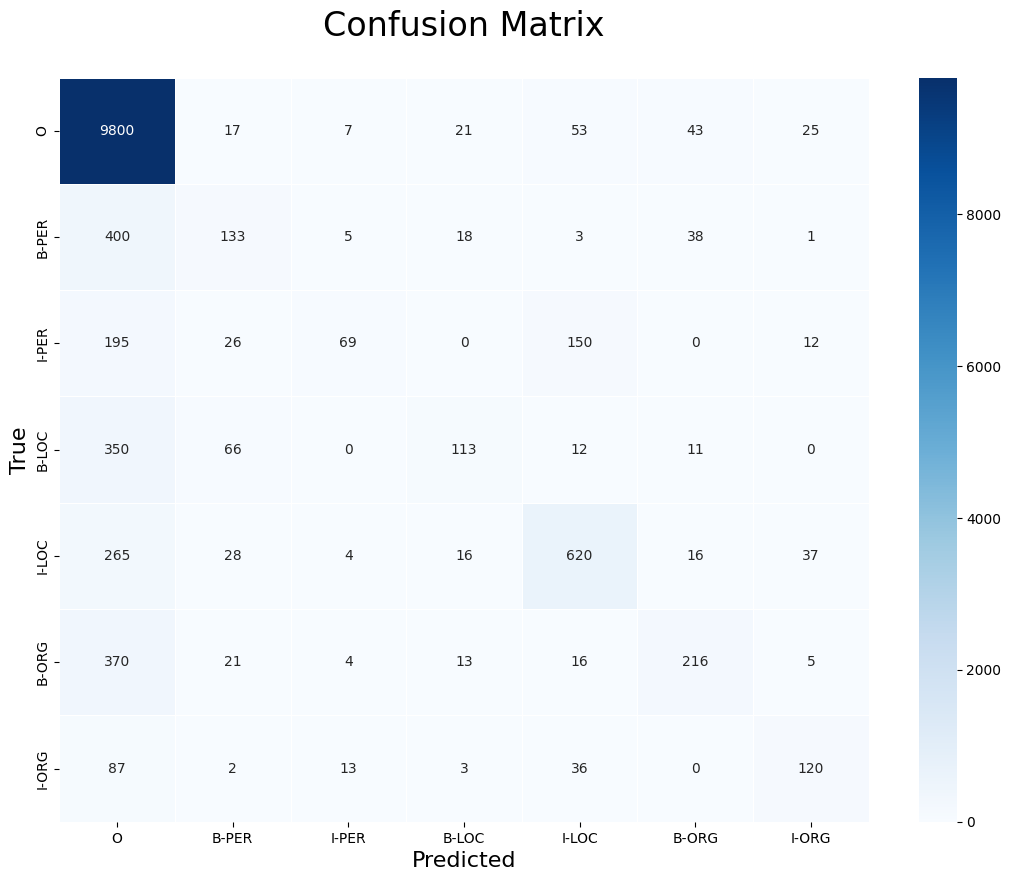

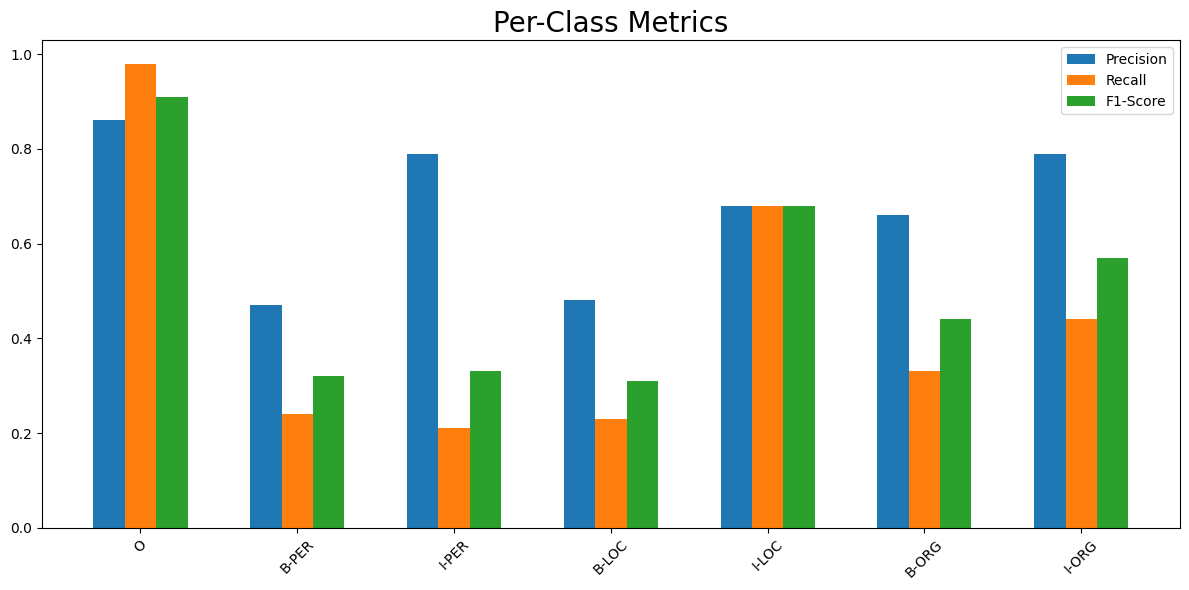

In [12]:
def evaluate_model(model, inputs, masks, labels, tag2id, id2tag):
    logger.info("Evaluating model")
    predictions = model.predict([inputs, masks])
    pred_labels = tf.argmax(predictions, axis=-1).numpy()

    true_labels_flat, pred_labels_flat = [], []

    for t, p, m in zip(labels, pred_labels, masks):
        mask = t != -100
        true_labels_flat.extend(t[mask])
        pred_labels_flat.extend(p[mask])

    print("Classification Report:")
    print(classification_report(
        true_labels_flat,
        pred_labels_flat,
        target_names=[id2tag[i] for i in range(len(tag2id))],
        zero_division=0
    ))

    cm = confusion_matrix(true_labels_flat, pred_labels_flat)
    labels_list = [id2tag[i] for i in range(len(tag2id))]

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_list, yticklabels=labels_list, cbar=True, linewidths=0.5)
    plt.title('Confusion Matrix', fontsize=24, loc='center', pad=30)
    plt.xlabel('Predicted', fontsize=16)
    plt.ylabel('True', fontsize=16)
    plt.tight_layout(pad=5)
    plt.savefig('/content/drive/MyDrive/NER/Plots/confusion_matrix.png')
    plt.show()

    precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(true_labels_flat, pred_labels_flat, zero_division=0)
    plt.figure(figsize=(12, 6))
    x = np.arange(len(tag2id))
    plt.bar(x - 0.2, precision_per_class, 0.2, label='Precision')
    plt.bar(x, recall_per_class, 0.2, label='Recall')
    plt.bar(x + 0.2, f1_per_class, 0.2, label='F1-Score')
    plt.xticks(x, labels_list, rotation=45)
    plt.title('Per-Class Metrics', fontsize=20)
    plt.legend()
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/NER/Plots/per_class_metrics.png')
    plt.show()

evaluate_model(model, test_inputs, test_masks, test_labels_ids, tag2id, id2tag)

**Training Performanace**

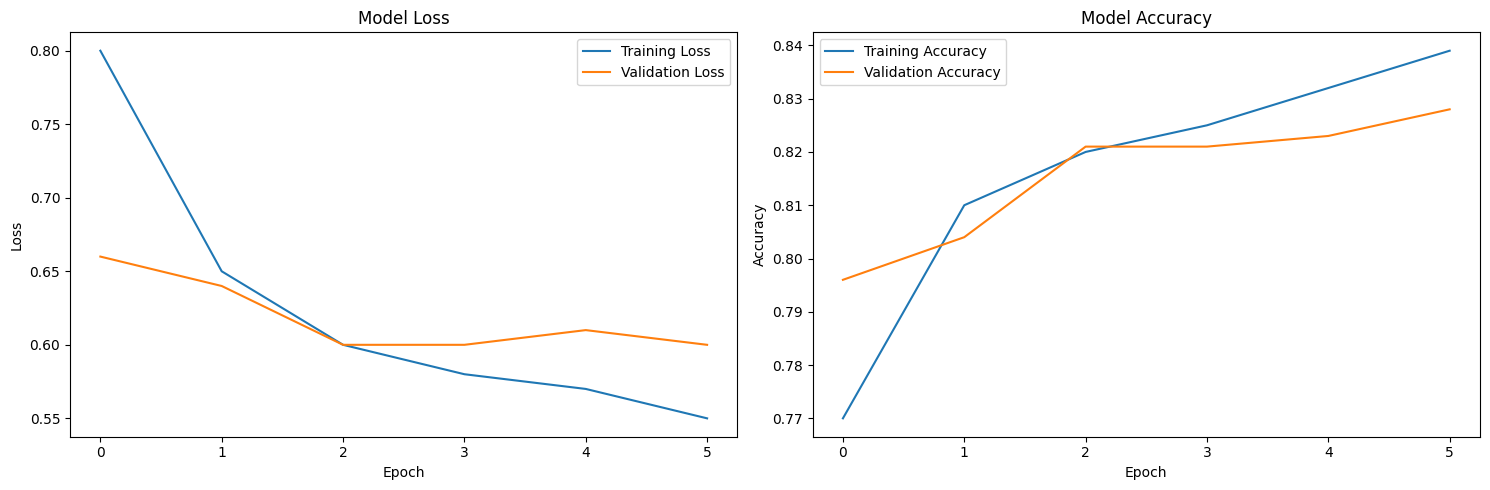

In [15]:
def plot_training_history(history):
    logger.info("Plotting training history")
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['custom_accuracy'], label='Training Accuracy')
    plt.plot(history['val_custom_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/Plots/training_performance.png')
    plt.show()

plot_training_history(history.history)

**Save Model**

In [32]:
logger.info("Saving model weights")
torch.save(model.state_dict(), '/content/drive/MyDrive/NER/Telugu_NER_model/pytorch_model.bin')

logger.info("Saving tokenizer and configuration files")
tokenizer.save_pretrained('/content/drive/MyDrive/NER/Telugu_NER_model')

logger.info("Saving model config file")
model.config.save_pretrained('/content/drive/MyDrive/NER/Telugu_NER_model')

print("Model and tokenizer saved successfully")

Model and tokenizer saved successfully
